In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [2]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data

file_name = "pendulum_200_200"
data = np.load("data/" + file_name + ".npz")
data, params = data["data"], data["params"]

E = params[:,0]
data = preprocess(data, MaxAbsScaler)

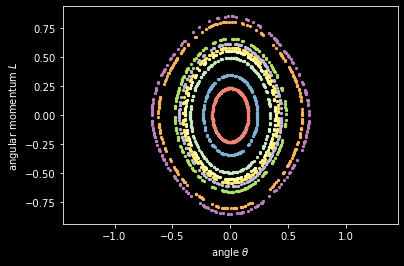

In [3]:
for traj in data[:10]:
    plt.scatter(traj[:,0], traj[:,1], s=5.)
plt.xlabel(r"angle $\theta$")
plt.ylabel(r"angular momentum $L$")
plt.axis('equal');

Converged? True
[]


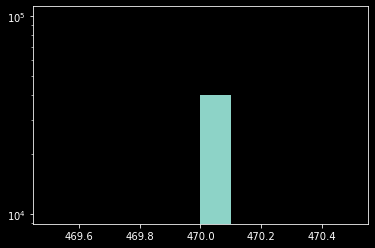

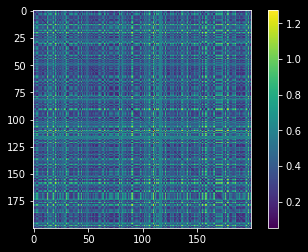

In [4]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [13]:
# np.savez(file_name + "_dist_mat.npz", dist_mat=dist_mat)
# dist_mat = np.load(file_name + "_dist_mat.npz")['dist_mat']

In [14]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=20, alpha=1, robust=True)

nn_max = 0.47491130232810974
epsilon = 0.4510814901579625
mean_shift = 0.008306567


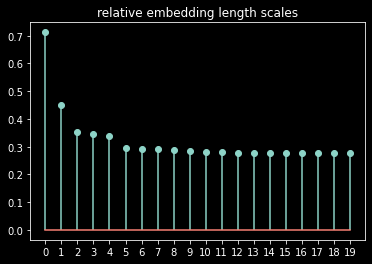

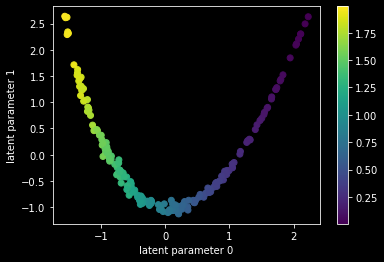

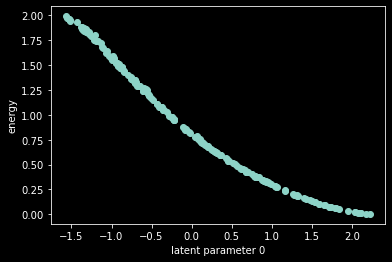

In [15]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], c=E)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 1")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:,0], E)
plt.xlabel("latent parameter 0")
plt.ylabel("energy");

[0]


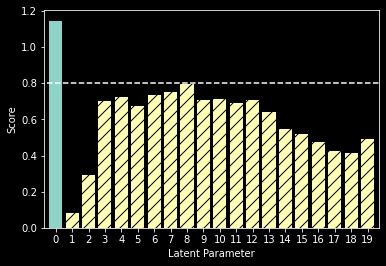

In [16]:
threshold = 0.8
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="standard")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

[0]


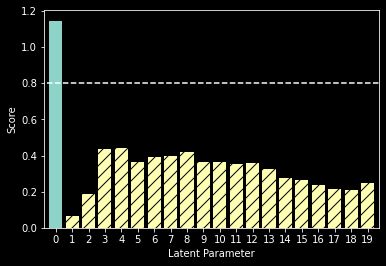

In [17]:
threshold = 0.8
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

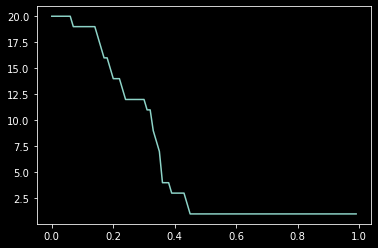

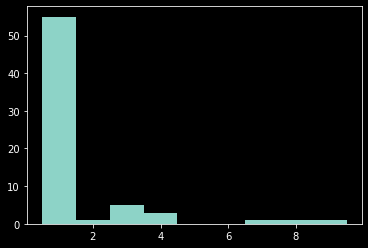

In [18]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

R^2 = 0.9990218336987929
Coefficent(s): [-0.35579002]


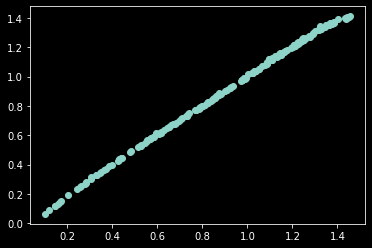

In [19]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = np.sqrt(E)
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y);